# CONSTRUIR UNA RED NEURONAL

Las *redes neuronales* utilizan capas/módulos para realizar operaciones con datos. `torch.nn` provee todo los bloques que se necesitan para construir una *red neuronal*. Todos los modulos de **PyTorch** son subclases de `nn.Module`. Un *red neuronal* es un módulo formado por otro módulos (o capas). Esta arquitectura anidada permite crear arquitecturas complejas en forma simple.

In [1]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

Es preferible utilizar el GPU para entrenar un modelo. El siguiente comando confirma si existe un GPU disponible y si no utiliza el CPU.

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cpu device


## Definir la clase

Se denfine *una red* neuronal declarando una subclase de `nn.module` e inicializando las capas de la *red neuronal* con el método `__init__`. Todas las subclases de `nn.Module` implementan las operaciones en los datos de entrada en el metodo `forward`.

In [3]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
            nn.ReLU()
        )
        
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

Creamos un instancia de `NeuralNetwork`, la movemos a `device`, e imprimimos su extructura.

In [4]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
    (5): ReLU()
  )
)


Para utilizar `model`, le pasamos los datos de entrada. Esto ejecuta la función `forward` del modelo, junto con otras operaciones de fondo. No hay que llamar al método `model.foward()` en forma directa!

Al ejecutar `model` retorna un tensor de 10 dimensiones con los valores predichos para cada clase. Obtenemos las probabilidades de cada predicción pasandolas por una instancia de `nn.softmax`.

In [5]:
X = torch.rand(1, 28, 28, device=device)
logits = model(X)
pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)
print(f"Predicted class: {y_pred}")

Predicted class: tensor([2])


## Las capas del modelo

Para ilustrarlo vamos a utilizar un minibatch de 3 imagenes de tamaño 28x28 y ver que sucede cuando pasa por la red.

In [8]:
input_image = torch.rand(3, 28, 28)
print(input_image.size())

torch.Size([3, 28, 28])


### nn.Flatten

Inicializamos la capa `nn.Flatten` para convertir cada imagen de 2D 28x28 a un array continuo de 784 pixeles.

In [9]:
flatten = nn.Flatten()
flat_image = flatten(input_image)
print(flat_image.size())

torch.Size([3, 784])


In [10]:
layer1 = nn.Linear(in_features=28*28, out_features=20)
hidden1 = layer1(flat_image)
print(hidden1.size())

torch.Size([3, 20])


En la siguiente imagen se ve un ejemplo de una capa de red neuronal creada con `nn.Linear(2, 1)`



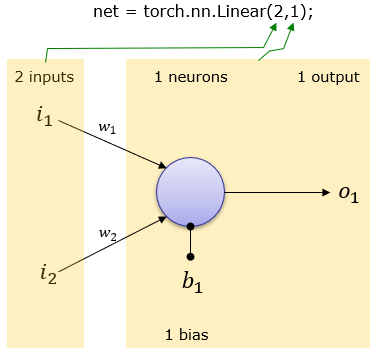

### nn.ReLU

Las funciones de activación no lineales son las que crean los mappeos complejos entre las entradas del modelo y las salidas. Se aplican luego de las tranformación lineal para introducir "no linearidad".

In [11]:
print(f"Before ReLU: {hidden1}\n\n")
hidden1 = nn.ReLU()(hidden1)
print(f"After ReLU: {hidden1}\n\n")

Before ReLU: tensor([[ 0.4035, -0.0317,  0.2024,  0.7635,  0.3066,  0.3425, -0.2890,  0.4507,
          0.2533, -0.2514,  0.1616, -0.2055, -0.4085, -0.2615, -0.2638,  0.6675,
         -0.0857,  0.2037,  0.4460, -0.1919],
        [ 0.3878,  0.1168,  0.4852,  0.3985,  0.3755,  0.1030, -0.4621,  0.1457,
          0.3751, -0.2191,  0.1133, -0.0912,  0.3227, -0.4854, -0.1312,  0.3717,
         -0.1870,  0.2211,  0.4656,  0.0852],
        [ 0.4146,  0.3923,  0.3215,  0.4586,  0.2428,  0.3131, -0.3706,  0.4674,
          0.1113, -0.1008,  0.0722, -0.0787, -0.1537, -0.2402, -0.1094,  0.5260,
          0.3706,  0.2243,  0.3442, -0.1487]], grad_fn=<AddmmBackward>)


After ReLU: tensor([[0.4035, 0.0000, 0.2024, 0.7635, 0.3066, 0.3425, 0.0000, 0.4507, 0.2533,
         0.0000, 0.1616, 0.0000, 0.0000, 0.0000, 0.0000, 0.6675, 0.0000, 0.2037,
         0.4460, 0.0000],
        [0.3878, 0.1168, 0.4852, 0.3985, 0.3755, 0.1030, 0.0000, 0.1457, 0.3751,
         0.0000, 0.1133, 0.0000, 0.3227, 0.0000, 0.000

ReLU es un acrónimo de **Rectified Linear Unit**:

$$ReLU(x) = (x)^+ = max(0, x)$$

Dada una antrada x, ReLU toma el valor máximo entre 0 y x.

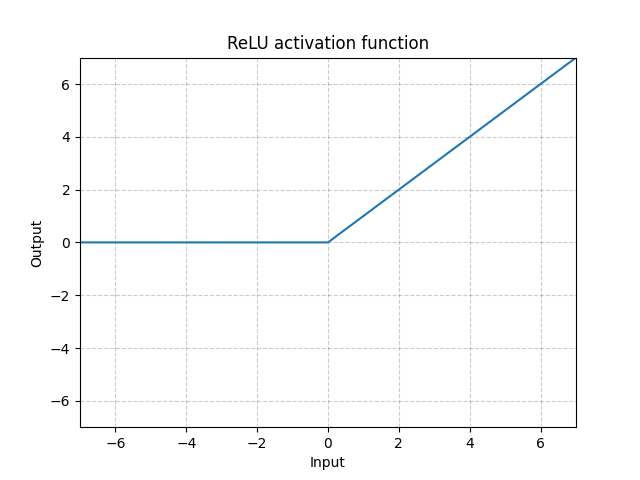

### nn.Sequencial

`nn.Sequencial` es un contenedor ordenado de modulos. Los datos se pasan en el mismo orden al que fueron definidos.

In [13]:
seq_modules = nn.Sequential(
    flatten,
    layer1,
    nn.ReLU(),
    nn.Linear(20, 10)
)

input_image = torch.rand(3, 28, 28)
logits = seq_modules(input_image)

### nn.Softmax

La última capa lineal de la *red neuronal* retorna *logits* valores en el rango [-infty, infty] los que son pasados al módulo `nn.Softmax`. Los *logits* son escalados a valores entre [0, 1] representando la probabilidades predichas para cada clase. El parámero `dim` indica la dimension sobre la cual los valores deben sumar 1.

In [15]:
softmax = nn.Softmax(dim=1)
pred_probab = softmax(logits)

### Parámetros del modelo

Muchas de las capas dentro del modelo se encuentra *parametrizadas*, por ejemplo los pesos y sesgos que son optimizados durante el proceso de entrenamiento. Al crear una subclase de `nn.Module` automaticamente todos estos campos son guardados dentro del modelo y son accesibles a través de los métodos `parameters()` o `named_parameters`.

En el siguiente ejemplo iteramos sobre los parametros e imprimimos su tamaño y sus valores.

In [ ]:
print("Model structure: ", model, "\n\n")

for name, param in model.named_parameters():
    print(f")